# Alex Net with Pytorch
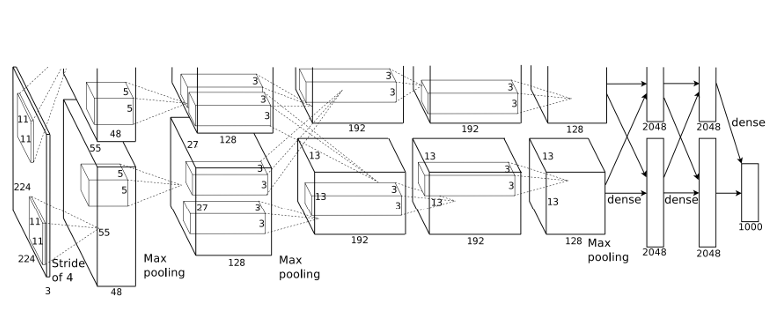

### 1. 데이터 로드하기
- fashion MNIST 데이터셋
    - training set : 60000
    - test set : 10000
    - 28*28 grayscale image
    - labels of 10 classes

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torchvision # torchvision package : 컴퓨터 비전을 위한 유명 데이터셋, 모델 아키텍처, 이미지 변형등을 포함
import torch.nn as nn # nn : neural netwroks (define class) attribute를 활용해 state를 저장하고 활용
import torch.optim as optim # 최적화 알고리즘
import torch.nn.functional as F # (define function) 인스턴스화 시킬 필요없이 사용 가능
from PIL import Image
from torchvision import transforms, datasets # transforms : 데이터를 조작하고 학습에 적합하게 만듦.
from torch.utils.data import Dataset, DataLoader
# dataset : 샘플과 정답(label)을 저장
# DataLoader : Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

In [5]:
epochs = 10
batch_size = 512

device = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
transform = transforms.Compose([
    transforms.Resize(227), # Compose : transforms 리스트 구성
    # 227x227 : input image(in alexnet) but fashionMNIST's input image : 28x28
    transforms.ToTensor()]) # ToTensor : PIL image or numpy.ndarray를 tensor로 바꿈

training_data = datasets.FashionMNIST(
    root="data", # data가 저장될 경로(path)
    train=True, # training dataset
    download=True, # 인터넷으로부터 데이터 다운
    transform=transform # feature 및 label 변환(transformation) 지정
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False, # test dataset
    download=True,
    transform=transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [7]:
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

### 2. 이미지 출력 함수 정의

Ankle boot


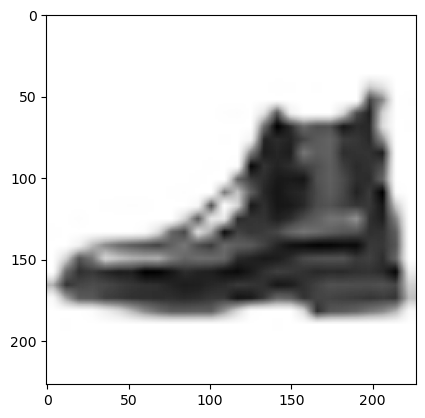

In [10]:
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

dataiter = iter(training_loader) # iter(호출 가능한 객체, 반복을 끝낼 값)
images, labels = dataiter.next() # next : 반복할 수 있을 때는 해당 값 출력, 반복 끝나면 기본값 출력

img_grid = torchvision.utils.make_grid(images[0]) # make_grid : 이미지의 그리드 생성

matplotlib_imshow(img_grid)
print(class_names[labels[0]])

### 3. AlexNet 모델 구현
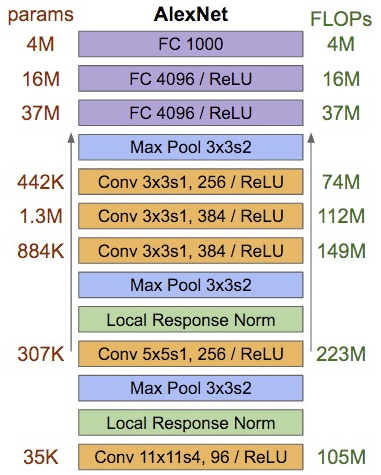

- conv layer 5개와 fc layer 3개

### 3.1 conv 복습

torch.nn.Conv2d(
-    in_channels, : input 채널 몇장
-    out_channels, : 필터 몇장
-    kernel_size, : 커널 사이즈 (괄호로 싸서 표현 가능 x by y)
-    stride=1, 
-    padding=0,
-    dilation=1,
-    groups=1,
-    bias=True


)

입력의 형태
- conv = nn.Conv2d(1,1,3)
- output = conv(input) <- 여기에서 input의 형태는 torch.Tensor 타입
- input shape : ( N * C * H * W ) 
=> (batch_size, channel, height, width)

output 크기
- output size : (input size - filter size + (2*padding))/stride + 1

In [19]:
class fashion_mnist_alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            # 입력 채널에 1장이 들어오고 필터 96장을 사용할 것임
            # 11*11 크기, padding=0의 커널을 사용함
            
            # input size(사진 크기) : 1*227*227
            # input size 정의 : (N, C, H, W) or (C, H, W)
            # W' = (W-F+2P)/S + 1
            # 결과로 55*55*96 map 생성
            # 227 -> 55
            
            nn.ReLU(), # 96*55*55
            nn.MaxPool2d(kernel_size=3, stride=2)
            # 96*27*27 map 생성

        )
        
        self.conv2 = nn.Sequential(
        
            nn.Conv2d(96, 256, 5, 1, 2),
            # 256*27*27
            nn.ReLU(),
            nn.MaxPool2d(3,2)
            # 27->13
            # 256*13*13
        
        )
        
        self.conv3 = nn.Sequential(
        
            nn.Conv2d(256, 384, 3,1,1),
            nn.ReLU()
            # 384*13*13
        
        )
        
        self.conv4 = nn.Sequential(
        
            nn.Conv2d(384, 384, 3,1,1),
            nn.ReLU()
            # 384*13*!3
            
        )
        
        self.conv5 = nn.Sequential(
        
            nn.Conv2d(384, 256, 3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(3,2) # 13 -> 6
            # 384*6*6
            
        )
        
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out) # 64x4096x1x1
        out = out.view(out.size(0), -1) # 64*4096
        
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [20]:
model = fashion_mnist_alexnet().to(device)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())

In [21]:
from torchsummary import summary as summary_

summary_(model, (1,227,227), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 96, 55, 55]          11,712
              ReLU-2          [512, 96, 55, 55]               0
         MaxPool2d-3          [512, 96, 27, 27]               0
            Conv2d-4         [512, 256, 27, 27]         614,656
              ReLU-5         [512, 256, 27, 27]               0
         MaxPool2d-6         [512, 256, 13, 13]               0
            Conv2d-7         [512, 384, 13, 13]         885,120
              ReLU-8         [512, 384, 13, 13]               0
            Conv2d-9         [512, 384, 13, 13]       1,327,488
             ReLU-10         [512, 384, 13, 13]               0
           Conv2d-11         [512, 256, 13, 13]         884,992
             ReLU-12         [512, 256, 13, 13]               0
        MaxPool2d-13           [512, 256, 6, 6]               0
           Linear-14                [51

### 4. train 정의

In [22]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # enumberate() : 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 항상 backpropagation 하기전에 미분(gradient)을 zero로 만들어주고 시작해야 한다.
        output = model(data)
        loss = criterion(output, target) # criterion = loss_fn
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step() # step() : 파라미터를 업데이트함
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### 5. test 정의

In [23]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

### 6. 훈련

In [ ]:
for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)